In [1]:
from jax0planet.light_curve import EclipsoidSystem, OblateBody, OblateTransitOrbit, oblate_lightcurve

from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import jax
import jax.numpy as jnp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2, 0.1]),
          'b':1.0,
          'bo':0.8,
          'duration':0.4
}

orbit = TransitOrbit(
    period=params['period'], time_transit=0, duration=params['duration'], impact_param=params['bo'], radius=params['radius']
)
oblate_orbit = OblateTransitOrbit(
    period=params['period'], time_transit=0, duration=params['duration'], impact_param=params['bo'], radius=params['radius'], f=0, theta=0
)

t = jnp.linspace(-0.3, 0.3, 200)
lc = jax.vmap(limb_dark_light_curve(orbit, params['u']))(t)

oblate_lc = oblate_lightcurve(orbit=oblate_orbit, u=params['u'], t=t)

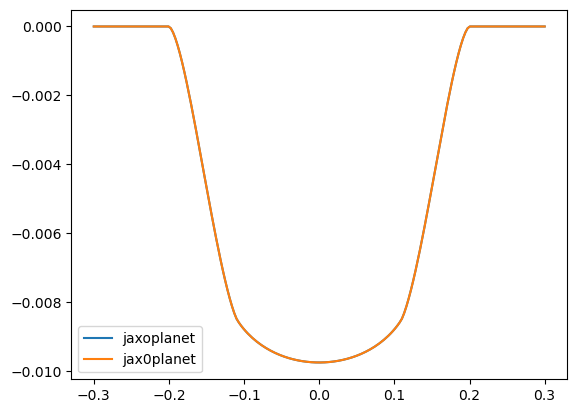

In [6]:
import matplotlib.pyplot as plt
plt.plot(t, lc, color="C0", label='jaxoplanet')
plt.plot(t, oblate_lc-1., color="C1", label='jax0planet')
plt.legend()